In [40]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from Fetch import *

In [41]:
%%time
final = set()
for distance in range(1000,21000,1000):
    final = final.union(get(distance))    
resd = dict()
resd['name'] = []
resd['lat'] = []
resd['lon'] = []
for (x,y,name) in final :
    resd['lat'].append(x)
    resd['lon'].append(y)
    resd['name'].append(name)
tdf = pd.DataFrame.from_dict(resd)
tdf.to_csv('ResidentialAreas.csv',index=0)
print("Residential Areas Marked")

Residential Areas Marked


In [42]:
%%time
from time import sleep
import os
resd_cnt = dict()
resd_cnt['lat'] = tdf['lat']
resd_cnt['lon'] = tdf['lon']
for name in req_cat.keys():
    tmp = []
    for (x,y) in zip(tdf['lat'],tdf['lon']):
        tmp.append(get_cat(x,y,req_cat[name]))
        sleep(0.2)
    resd_cnt[name]=tmp
rdf = pd.DataFrame.from_dict(resd_cnt)
rdf.to_csv("ResidentialAreasNeighbourhood.csv",index=0)
print("Neighbourhood of Each Residential Building Marked")

Neighbourhood of Each Residential Building Marked
CPU times: user 21.3 s, sys: 1.87 s, total: 23.1 s
Wall time: 5min 22s


In [43]:
rdf.head()

,lat,lon,Restaurant,Fruit and Vegetable,Grocery Store,Health and Medicine,Sweets and Snacks,Metro Station
0,28.545362,77.291345,50,0,0,12,0,1
1,28.662578,77.380580,50,0,2,50,0,0
2,28.645793,77.382985,50,0,6,49,1,0
3,28.628907,77.317984,17,0,2,8,0,1
4,28.642691,77.321338,50,0,3,41,0,1


In [44]:
X = np.array(rdf.drop(['lat','lon'],axis=1))
X = np.stack(X)

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

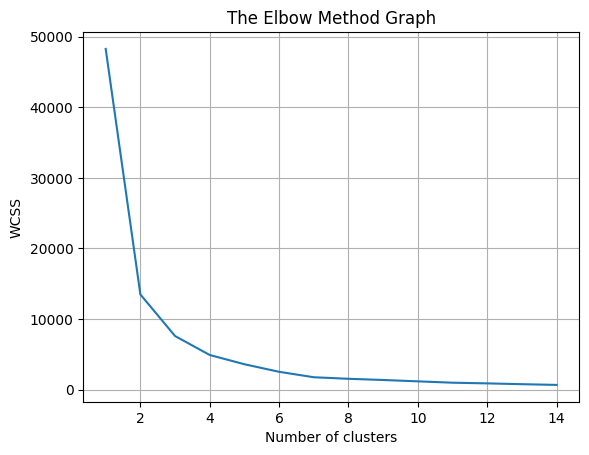

In [46]:
wcss = []
maxsize = 15
for cluster_size in range(1,maxsize):
    kmeans = KMeans(n_clusters=cluster_size, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,maxsize),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [56]:
optimal = 2
kmeans = KMeans(n_clusters=optimal, init='k-means++', max_iter=1000, n_init=125, random_state=0)
y_kmeans = kmeans.fit_predict(X_pca)
rdf['cluster']=y_kmeans

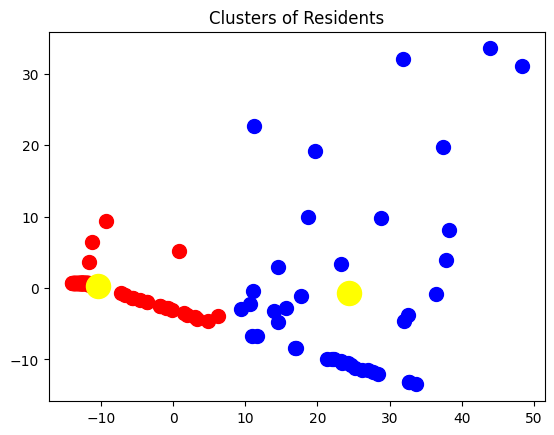

In [58]:
plt.scatter(X_pca[y_kmeans==0, 0], X_pca[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_pca[y_kmeans==1, 0], X_pca[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Residents')
plt.show()

In [49]:
mapping = dict()
for name,x,y in zip(tdf.name,tdf.lat,tdf.lon):
    mapping[(x,y)]=name

In [51]:
import folium
this_map = folium.Map(prefer_canvas=True)
latlon = [(x,y,c) for x,y,c in zip(rdf['lat'],rdf['lon'],rdf['cluster'])]
coloring = {0:'red', 1:'blue', 2:'yellow'}
for coord in latlon:
    folium.CircleMarker(location=[coord[0], coord[1]],
                        radius=2,
                        weight=5,
                        color=coloring[coord[2]],
                        popup=mapping[(coord[0],coord[1])]).add_to(this_map)
this_map.fit_bounds(this_map.get_bounds())
this_map